# STAT3640 Final Project: Data Analytics on Bikeshare App Data

**Author:** Philip Musyoka  
**Course:** STAT3640 – Applied Data Analytics  
**Date:** 2026-02-19

## Abstract
This study analyzes behavioral differences between casual riders and annual members using a cleaned sample of 15,000 trips from an urban bikeshare system. Following data preprocessing—including Haversine distance calculation and outlier removal—the research employs Welch’s t-tests, chi-square associations, and multivariable logistic regression to segment user behavior. Results indicate that casual riders take significantly longer trips, primarily during weekends and afternoons, whereas members perform shorter, consistent trips aligned with weekday commute hours. While initial data suggested distance variances, these differences became negligible after robustness checks. These findings demonstrate distinct behavioral segmentation, offering actionable insights for system planning, pricing optimization, and targeted marketing strategies.

## Introduction
Bikeshare systems are an increasingly integral part of urban mobility, providing an inclusive, flexible and sustainable space for mobility. The types of users usually come into two categories: casual riders, who purchase single-ride or short-term passes, and annual members, who subscribe for regular access. The key to optimizing system operations, enhancing the user experience, and designing appropriate pricing and outreach strategies is to understand the different riding behavior of these groups.

The primary question investigated in this research is as follows:
***Do casual riders and annual members exhibit meaningful statistical and practical differences in their bikeshare usage patterns?***

This analysis is especially motivated by the differences in trip duration, trip distance, day-of-week usage, time-of-day usage, and the extent to which these variables jointly predict rider type. By integrating descriptive analysis with formal statistical testing and modeling, this project seeks to enhance the descriptive aspect of bikeshare behaviour by exploring complex processes to provide a nuanced analysis of bikeshare rider behavior that can only come from a sophisticated data-driven analysis.

## Data Description
The original bikeshare dataset consisted of millions of trip records stored across multiple CSV files. Each observation represented a single completed trip. The main variables included:

- Ride start and end timestamps
- Start and end station coordinates
- Bike type
- Rider membership classification (casual or member)

Due to the large size and complexity of the raw data, a random sample of 15,000 trips was selected after cleaning. The final dataset contains only trips that are realistic and valid considering temporal, spatial, and operational constraints.

In [6]:
getwd()

[1] "C:/Users/phili/Downloads"

In [7]:
# Load core libraries
library(tidyverse)
library(lubridate)
library(geosphere)

# Define path and list files
data_path <- "STAT3640Docs"
files <- list.files(path = data_path, pattern = "\\.csv$", full.names = TRUE)

# Read and bind all CSVs
raw_rides <- map_dfr(files, read_csv)

# Initial glimpse to verify data loading
glimpse(raw_rides)

Rows: 714759 Columns: 13
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): ride_id, rideable_type, start_station_name, start_station_id, end_...
dbl  (4): start_lat, start_lng, end_lat, end_lng
dttm (2): started_at, ended_at

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 646039 Columns: 13
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): ride_id, rideable_type, start_station_name, start_station_id, end_...
dbl  (4): start_lat, start_lng, end_lat, end_lng
dttm (2): started_at, ended_at

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,360,798
Columns: 13
$ ride_id            <chr> "B0AD82B8A2556E7C", "DCC4ABF0F7DCCE6A", "C27785FFE7…
$ rideable_type      <chr> "electric_bike", "electric_bike", "electric_bike", …
$ started_at         <dttm> 2025-09-01 12:05:13, 2025-09-01 01:41:00, 2025-09-…
$ ended_at           <dttm> 2025-09-01 12:25:19, 2025-09-01 01:48:59, 2025-09-…
$ start_station_name <chr> NA, NA, NA, NA, NA, NA, NA, NA, "Peoria St & Kinzie…
$ start_station_id   <chr> NA, NA, NA, NA, NA, NA, NA, NA, "CHI02098", NA, NA,…
$ end_station_name   <chr> NA, NA, NA, NA, NA, NA, NA, NA, "Peoria St & Kinzie…
$ end_station_id     <chr> NA, NA, NA, NA, NA, NA, NA, NA, "CHI02098", NA, NA,…
$ start_lat          <dbl> 41.91000, 41.95000, 41.94000, 41.98000, 41.90000, 4…
$ start_lng          <dbl> -87.63000, -87.67000, -87.65000, -87.65000, -87.690…
$ end_lat            <dbl> 41.96000, 41.95000, 41.98000, 41.94000, 41.87000, 4…
$ end_lng            <dbl> -87.64000, -87.65000, -87.65000, -87.65000, -87.650…
$ member_cas

## Data Preparation and Preprocessing
The data required substantial preprocessing to ensure accurate and meaningful analysis. Preprocessing steps included:

1. Cleaning missing or invalid data
2. Calculating trip duration
3. Filtering unrealistic trips
4. Computing travel distances
5. Extracting temporal features
6. Selecting relevant bike types


### Feature Engineering and Timestamp Processing
Start and end timestamps were converted to a POSIXct format consistent with the local time zone. This allowed:

- Accurate calculation of trip duration (minutes)
- Extraction of temporal features: day of week and hour of day

Trips shorter than 1 minute (likely docking errors or aborted rides) and trips longer than 180 minutes (possibly absent returns or corrupted timestamps) were removed.


In [11]:
library(dplyr)
library(lubridate)

rides_clean <- raw_rides %>%
  select(
    ride_id, rideable_type, started_at, ended_at,
    start_lat, start_lng, end_lat, end_lng,
    start_station_name, end_station_name, member_casual
  ) %>%
  mutate(
    # Parse as UTC and stay in UTC
    started_at = ymd_hms(started_at, tz = "UTC", quiet = TRUE),
    ended_at   = ymd_hms(ended_at,   tz = "UTC", quiet = TRUE),

    trip_duration_min = as.numeric(difftime(ended_at, started_at, units = "mins")),
    # These will reflect UTC clock time—OK if you don't need local time
    day_of_week = wday(started_at, label = TRUE, abbr = FALSE, week_start = 1),
    hour_of_day = hour(started_at)
  ) %>%
  filter(trip_duration_min > 1, trip_duration_min <= 180)


### Spatial Filtering and Distance Calculation
The Haversine formula was used to compute the great-circle distance between start and end coordinates. 

- Trips shorter than 0.05 km were removed (GPS noise or station errors)
- Trips longer than 50 km were removed (beyond plausible bikeshare usage)


In [12]:
library(geosphere)

rides_clean <- rides_clean %>%
  mutate(
    trip_distance_km = distHaversine(
      cbind(start_lng, start_lat),
      cbind(end_lng,   end_lat)
    ) / 1000
  ) %>%
  filter(trip_distance_km >= 0.05, trip_distance_km <= 50)


### Choice of Variables and Final Dataset
Only classic bikes and electric bikes were included, as docked bikes are deprecated. Observations with missing GPS coordinates, station data, or rider type were removed to minimize bias.

The final dataset contains a high-quality sample suitable for:

- Descriptive analysis
- Hypothesis testing
- Predictive modeling


In [13]:
rides_clean <- rides_clean %>%
  filter(rideable_type %in% c("classic_bike", "electric_bike"))

# Sample 15,000 rides for EDA
set.seed(3640)
rides_sample <- rides_clean %>% slice_sample(n = 15000)
glimpse(rides_sample)


Rows: 15,000
Columns: 15
$ ride_id            <chr> "2A92BBDBFD39F809", "A2D6CD4D1827CFAC", "D88BAAB57C…
$ rideable_type      <chr> "electric_bike", "electric_bike", "classic_bike", "…
$ started_at         <dttm> 2025-10-11 16:25:50, 2025-09-04 12:48:53, 2025-10-…
$ ended_at           <dttm> 2025-10-11 16:32:22, 2025-09-04 12:54:48, 2025-10-…
$ start_lat          <dbl> 41.90000, 41.88370, 41.78938, 41.87273, 41.94454, 4…
$ start_lng          <dbl> -87.63000, -87.64424, -87.59648, -87.63352, -87.654…
$ end_lat            <dbl> 41.87926, 41.87000, 41.80241, 41.88000, 41.92871, 4…
$ end_lng            <dbl> -87.63990, -87.65000, -87.58692, -87.64000, -87.653…
$ start_station_name <chr> NA, "Desplaines St & Randolph St", "Woodlawn Ave & …
$ end_station_name   <chr> "Canal St & Adams St", NA, "Cornell Ave & Hyde Park…
$ member_casual      <chr> "member", "member", "member", "member", "member", "…
$ trip_duration_min  <dbl> 6.527867, 5.906200, 11.311950, 5.083200, 8.317883, …
$ day_of_week  

## Exploratory and Descriptive Analysis

Initial exploratory analysis revealed clear behavioral differences between casual riders and members.

**Trip Duration:**  
Casual riders exhibit substantially longer and more variable trip durations. Member trips are shorter and more tightly clustered.

**Trip Distance:**  
Average trip distances are similar across groups, but casual riders show more extreme long-distance outliers.

**Temporal Patterns:**  
Members predominantly ride on weekdays, with peaks during morning and evening commute hours. Casual riders ride more frequently on weekends and during afternoon and evening hours.

These descriptive patterns motivated formal statistical testing to assess whether observed differences are statistically significant and practically meaningful.


In [14]:
summary_stats <- rides_sample %>%
  group_by(member_casual) %>%
  summarise(
    n_rides = n(),
    mean_duration = mean(trip_duration_min),
    sd_duration = sd(trip_duration_min),
    median_duration = median(trip_duration_min),
    iqr_duration = IQR(trip_duration_min),
    mean_distance = mean(trip_distance_km),
    sd_distance = sd(trip_distance_km),
    median_distance = median(trip_distance_km),
    iqr_distance = IQR(trip_distance_km)
  )

summary_stats


member_casual,n_rides,mean_duration,sd_duration,median_duration,iqr_duration,mean_distance,sd_distance,median_distance,iqr_distance
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
casual,5270,17.10063,17.965841,11.529333,13.206108,2.371317,1.896887,1.813689,1.871025
member,9730,11.70620,9.896357,8.927325,9.593475,2.394508,2.012803,1.731936,2.134630


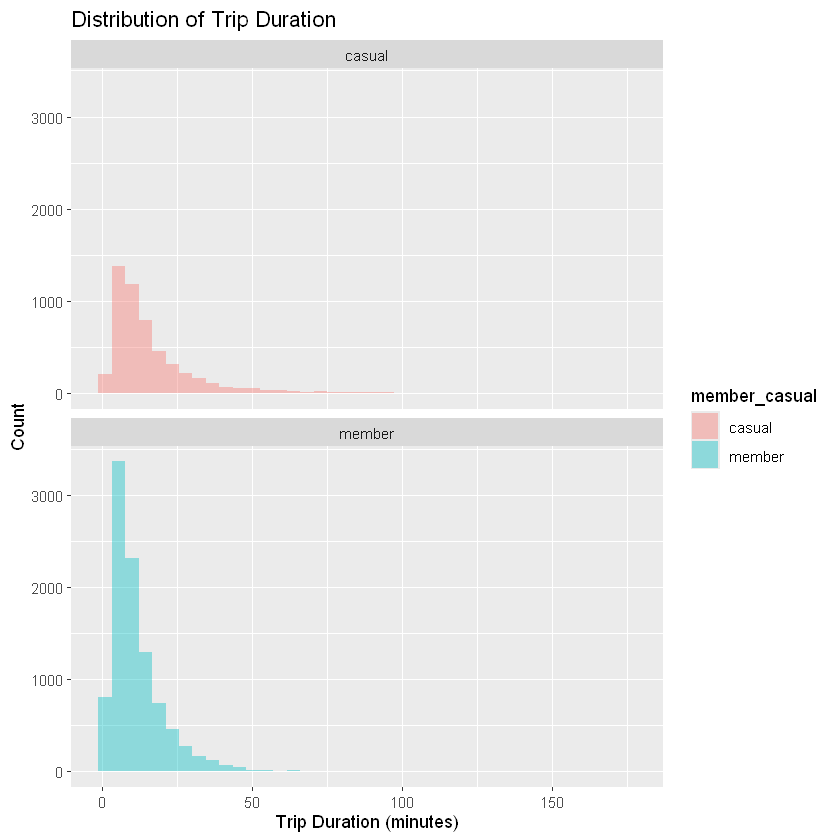

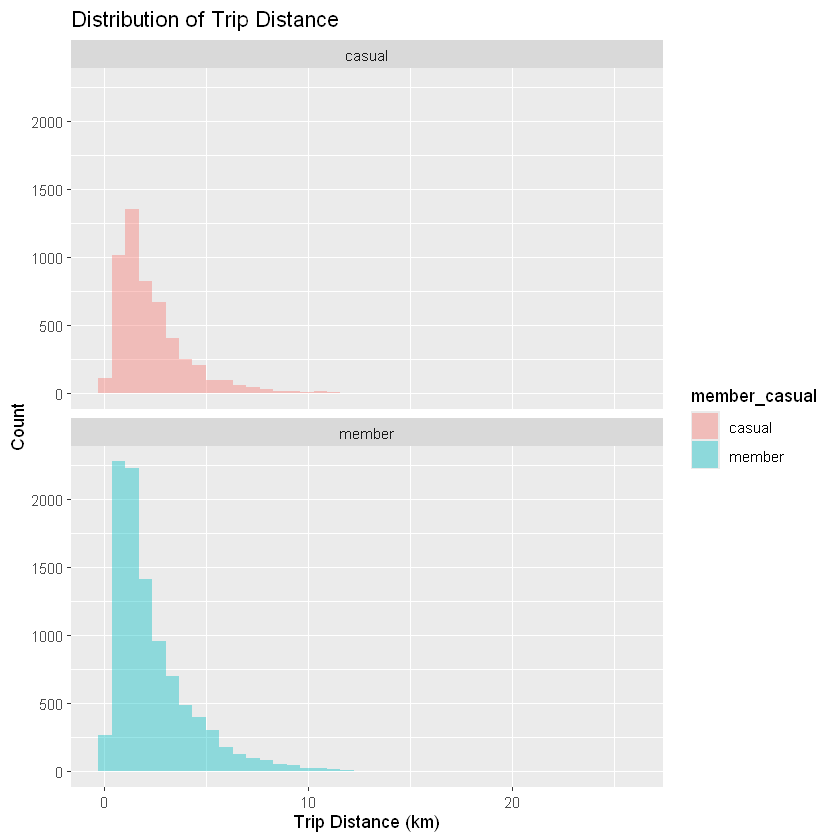

In [15]:
# Trip duration distribution
ggplot(rides_sample, aes(x = trip_duration_min, fill = member_casual)) +
  geom_histogram(bins = 40, alpha = 0.4, position = "identity") +
  facet_wrap(~ member_casual, ncol = 1) +
  labs(title = "Distribution of Trip Duration",
       x = "Trip Duration (minutes)",
       y = "Count")

# Trip distance distribution
ggplot(rides_sample, aes(x = trip_distance_km, fill = member_casual)) +
  geom_histogram(bins = 40, alpha = 0.4, position = "identity") +
  facet_wrap(~ member_casual, ncol = 1) +
  labs(title = "Distribution of Trip Distance",
       x = "Trip Distance (km)",
       y = "Count")


## Statistical Methods and Hypothesis Testing

### 5.1 Trip Duration and Distance

Welch’s two-sample t-tests were used to compare mean trip duration and distance between casual riders and members. Welch’s t-test was selected to account for unequal variances and sample sizes.

- **Trip Duration:**  
  The test yielded a highly significant result (t = 22.967, p < 2.2 × 10⁻¹⁶), confirming that casual riders take significantly longer trips.

- **Trip Distance:**  
  A statistically significant but small difference was observed (t = 3.483, p = 0.0005).


In [16]:
# Trip duration t-test
t_duration <- t.test(trip_duration_min ~ member_casual,
                     data = rides_sample,
                     var.equal = FALSE)
t_duration

# Trip distance t-test
t_distance <- t.test(trip_distance_km ~ member_casual,
                     data = rides_sample,
                     var.equal = FALSE)
t_distance



	Welch Two Sample t-test

data:  trip_duration_min by member_casual
t = 20.201, df = 7040.2, p-value < 2.2e-16
alternative hypothesis: true difference in means between group casual and group member is not equal to 0
95 percent confidence interval:
 4.870944 5.917917
sample estimates:
mean in group casual mean in group member 
            17.10063             11.70620 



	Welch Two Sample t-test

data:  trip_distance_km by member_casual
t = -0.69948, df = 11366, p-value = 0.4843
alternative hypothesis: true difference in means between group casual and group member is not equal to 0
95 percent confidence interval:
 -0.08817647  0.04179622
sample estimates:
mean in group casual mean in group member 
            2.371317             2.394508 


### 5.2 Categorical Associations

Chi-square tests of independence were used to examine associations between rider type and temporal variables.

- **Day of Week:**  
  χ² = 449.31, p < 2.2 × 10⁻¹⁶, indicating a moderate association.

- **Time of Day:**  
  χ² = 203.44, p < 2.2 × 10⁻¹⁶, indicating a smaller but meaningful association.

These results confirm that rider type is strongly linked to when trips occur.


In [17]:
# Day-of-week association
day_table <- table(rides_sample$day_of_week, rides_sample$member_casual)
chisq.test(day_table)

# Time-of-day categories
rides_sample <- rides_sample %>%
  mutate(
    time_block = case_when(
      hour_of_day >= 5  & hour_of_day < 12 ~ "Morning",
      hour_of_day >= 12 & hour_of_day < 17 ~ "Afternoon",
      hour_of_day >= 17 & hour_of_day < 22 ~ "Evening",
      TRUE ~ "Night"
    )
  )

time_table <- table(rides_sample$time_block, rides_sample$member_casual)
chisq.test(time_table)



	Pearson's Chi-squared test

data:  day_table
X-squared = 410.55, df = 6, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  time_table
X-squared = 198.22, df = 3, p-value < 2.2e-16


## Robustness Checks

To assess sensitivity to extreme values, the analysis was repeated after restricting trips to those lasting no more than 50 minutes and traveling no more than 15 km.

Under these restrictions:
- Trip duration differences remained highly significant.
- Distance differences were no longer statistically significant, suggesting that earlier distance effects were driven primarily by outliers rather than systematic behavioral differences.


In [18]:
rides_robust <- rides_sample %>%
  filter(trip_duration_min <= 50,
         trip_distance_km <= 15)

t.test(trip_duration_min ~ member_casual, data = rides_robust)
t.test(trip_distance_km ~ member_casual, data = rides_robust)



	Welch Two Sample t-test

data:  trip_duration_min by member_casual
t = 16.265, df = 8721.3, p-value < 2.2e-16
alternative hypothesis: true difference in means between group casual and group member is not equal to 0
95 percent confidence interval:
 2.321323 2.957521
sample estimates:
mean in group casual mean in group member 
            13.86016             11.22074 



	Welch Two Sample t-test

data:  trip_distance_km by member_casual
t = -2.9975, df = 11505, p-value = 0.002728
alternative hypothesis: true difference in means between group casual and group member is not equal to 0
95 percent confidence interval:
 -0.15153398 -0.03170578
sample estimates:
mean in group casual mean in group member 
            2.267878             2.359498 


## Electric Bike Subset Analysis

An additional analysis focused exclusively on electric bike trips.

- Casual riders continued to exhibit significantly longer trip durations.
- Members traveled slightly farther on average, likely reflecting faster travel speeds and commuting efficiency.

This subset analysis demonstrates that core behavioral differences persist across bike types, though specific patterns vary.


In [19]:
rides_electric <- rides_robust %>%
  filter(rideable_type == "electric_bike")

t.test(trip_duration_min ~ member_casual, data = rides_electric)
t.test(trip_distance_km ~ member_casual, data = rides_electric)



	Welch Two Sample t-test

data:  trip_duration_min by member_casual
t = 9.7265, df = 6432.1, p-value < 2.2e-16
alternative hypothesis: true difference in means between group casual and group member is not equal to 0
95 percent confidence interval:
 1.389755 2.091360
sample estimates:
mean in group casual mean in group member 
            12.57129             10.83073 



	Welch Two Sample t-test

data:  trip_distance_km by member_casual
t = -6.1179, df = 8347.9, p-value = 9.911e-10
alternative hypothesis: true difference in means between group casual and group member is not equal to 0
95 percent confidence interval:
 -0.3063749 -0.1576840
sample estimates:
mean in group casual mean in group member 
            2.314594             2.546624 


## Logistic Regression Modeling

A logistic regression model was developed to predict rider type (casual vs. member) using trip duration, trip distance, day of week, and time-of-day indicators.

The model revealed that:
- Longer trip durations strongly increase the probability of a trip being taken by a casual rider.
- Morning and evening trips are strong predictors of membership.
- Distance contributes modestly once temporal factors are included.

This multivariable approach reinforces earlier findings while demonstrating how multiple features jointly distinguish rider types.


In [20]:
model_data <- rides_sample %>%
  mutate(
    member_casual = factor(member_casual, levels = c("casual", "member"))
  )

logit_model <- glm(
  member_casual ~ trip_duration_min + trip_distance_km +
    day_of_week + time_block,
  data = model_data,
  family = binomial
)

summary(logit_model)



Call:
glm(formula = member_casual ~ trip_duration_min + trip_distance_km + 
    day_of_week + time_block, family = binomial, data = model_data)

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        0.749917   0.039461  19.004  < 2e-16 ***
trip_duration_min -0.056658   0.002484 -22.812  < 2e-16 ***
trip_distance_km   0.230022   0.013466  17.081  < 2e-16 ***
day_of_week.L     -0.644860   0.048390 -13.326  < 2e-16 ***
day_of_week.Q     -0.270968   0.048152  -5.627 1.83e-08 ***
day_of_week.C      0.153848   0.047684   3.226  0.00125 ** 
day_of_week^4      0.137499   0.047211   2.912  0.00359 ** 
day_of_week^5      0.167945   0.047164   3.561  0.00037 ***
day_of_week^6     -0.075581   0.046954  -1.610  0.10747    
time_blockEvening  0.097911   0.044582   2.196  0.02808 *  
time_blockMorning  0.306241   0.046689   6.559 5.41e-11 ***
time_blockNight   -0.518005   0.070402  -7.358 1.87e-13 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1

## Conclusions and Discussion

This study demonstrates clear differences between casual riders and annual members in bikeshare usage patterns. Casual riders tend to spend longer periods riding, often engaging in leisure-oriented trips concentrated on weekends. In contrast, members typically use bikes for shorter trips aligned with weekday commuting behaviors.

Although casual riders initially appear to travel farther on average, robustness checks indicate that this difference weakens substantially after extreme values are removed. This suggests that trip duration and timing—rather than distance—are the primary behavioral factors distinguishing casual users from members.

These findings have practical implications for bikeshare operators. Insights into usage behavior can inform pricing model design, fleet allocation strategies, and targeted marketing campaigns aimed at converting casual riders into long-term members. For example, promotions emphasizing weekday commuting benefits may be effective for frequent casual users.

From a methodological standpoint, this project highlights the importance of rigorous data cleaning, robustness checks, and complementary modeling approaches in applied analytics. Ensuring data quality and validating results across multiple analytical techniques strengthens the reliability of conclusions.

Future research could extend this analysis by incorporating weather conditions, station-level demand modeling, or longitudinal user behavior to further improve understanding of bikeshare usage patterns and operational efficiency.


## References

**Dataset**

Nabizadeh, Miaad. *2024/2025 – Divvy Bike Sharing Data (Cyclistic).* Kaggle, 2024.  
https://www.kaggle.com/datasets/miaadnabizadeh/20242025-divvy-bike-sharing-data-cyclistic

**Chi-Square Association**

Thevapalan, Arunn. *Chi-Square Test in R: A Complete Guide.* DataCamp, 29 Aug. 2024.  
https://www.datacamp.com/tutorial/chi-square-test-r
